# Enron Email Dataset

# Summary

In this brief challenge, I want to demonstrate some of my Data Science skills. 

I will work with the Enron Email Dataset, step by step, from data cleaning to data handling, apply basics statistics to understand the dataset and its features, further exploration and Data Analysis, presentation of the insights, track key points data and notice interesting patterns through data visualization tools. All my though process with appropriate comments are given inside the code.

I found extremely interesting the classification or email clustering, but I wanted to explore a more interesting area, POI. I want to see if the Machine Learning algorithms will be able to detect POIs and I hope to achieve that (implementation and results in the Conclusion section).  

# Import Libraries and Load Dataset

In [11]:
import os
import sys
import email
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import re
import wordcloud

from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer


from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD


from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

import random



Read the data into a DataFrame

In [12]:
file = "emails.csv"
emails_df = pd.read_csv(file, skiprows=lambda x:x%10)
# I am only going to use approximately 50.000 rows (1/10 of the full dataset), 
# because it would take a lot of time on the full dataset

# Data Cleaning/ Data Handling/ Statistical Analysis

In [13]:
print(emails_df.shape)
emails_df.head()

(51740, 2)


,file,message
0,allen-p/_sent_mail/102.,Message-ID: <30795301.1075855687494.JavaMail.e...
1,allen-p/_sent_mail/111.,Message-ID: <29177675.1075855687692.JavaMail.e...
2,allen-p/_sent_mail/120.,Message-ID: <29665600.1075855687895.JavaMail.e...
3,allen-p/_sent_mail/13.,Message-ID: <32300323.1075855378519.JavaMail.e...
4,allen-p/_sent_mail/139.,Message-ID: <9942513.1075855688311.JavaMail.ev...


In [14]:
# A single message looks like this
print(emails_df['message'][10])

Message-ID: <25730802.1075855689480.JavaMail.evans@thyme>
Date: Wed, 9 Aug 2000 07:11:00 -0700 (PDT)
From: phillip.allen@enron.com
To: colleen.sullivan@enron.com
Subject: Re: TRANSPORTATION MODEL
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Colleen Sullivan
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Colleen,

 I am out ot the office on Friday, but Keith Holst will attend.  He has been 
managing the Transport on the west desk.

Phillip


In [15]:
# Build functions that will help me in the cleaning process
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs


In [16]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages


emails_df.head()



,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/102.,<30795301.1075855687494.JavaMail.evans@thyme>,"Mon, 16 Oct 2000 06:44:00 -0700 (PDT)",(phillip.allen@enron.com),(zimam@enron.com),FW: fixed forward or other Collar floor gas pr...,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,zimam@enron.com,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p
1,allen-p/_sent_mail/111.,<29177675.1075855687692.JavaMail.evans@thyme>,"Tue, 3 Oct 2000 09:15:00 -0700 (PDT)",(phillip.allen@enron.com),(ina.rangel@enron.com),Meeting re: Storage Strategies in the West,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Ina Rangel,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p
2,allen-p/_sent_mail/120.,<29665600.1075855687895.JavaMail.evans@thyme>,"Tue, 26 Sep 2000 05:11:00 -0700 (PDT)",(phillip.allen@enron.com),(cindy.cicchetti@enron.com),Re: Gas Trading Vision meeting,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Cindy Cicchetti,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Nymex expiration is during this time frame. P...,allen-p
3,allen-p/_sent_mail/13.,<32300323.1075855378519.JavaMail.evans@thyme>,"Wed, 2 May 2001 12:36:00 -0700 (PDT)",(phillip.allen@enron.com),(james.steffes@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,James D Steffes <James D Steffes/NA/Enron@Enron>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,"Jim,\n\nIs there going to be a conference call...",allen-p
4,allen-p/_sent_mail/139.,<9942513.1075855688311.JavaMail.evans@thyme>,"Tue, 12 Sep 2000 00:27:00 -0700 (PDT)",(phillip.allen@enron.com),(moshuffle@hotmail.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,moshuffle@hotmail.com,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,http://www.hearme.com/vc2/?chnlOwnr=pallen@enr...,allen-p


In [17]:
print('shape of the dataframe:', emails_df.shape)
# Find number of unique values in each columns
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

shape of the dataframe: (51740, 18)
file 51740
Message-ID 51740
Date 44478
From 7304
To 16281
Subject 37234
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 2
X-From 9152
X-To 20143
X-cc 8044
X-bcc 15
X-Folder 3549
X-Origin 257
X-FileName 419
content 46230
user 150


In [18]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

Apply statistics to get information and description about the dataset

In [19]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51740 entries, <30795301.1075855687494.JavaMail.evans@thyme> to <22052556.1075842030013.JavaMail.evans@thyme>
Data columns (total 13 columns):
Date          51740 non-null object
From          51740 non-null object
To            49542 non-null object
Subject       51740 non-null object
X-From        51737 non-null object
X-To          51737 non-null object
X-cc          51737 non-null object
X-bcc         51737 non-null object
X-Folder      51737 non-null object
X-Origin      51737 non-null object
X-FileName    51737 non-null object
content       51740 non-null object
user          51740 non-null object
dtypes: object(13)
memory usage: 5.5+ MB


In [20]:
emails_df.describe()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
count,51740,51740,49542,51740,51737,51737,51737,51737,51737,51737,51737,51740,51740
unique,44478,7304,16281,37234,9152,20143,8044,15,3549,257,419,46230,150
top,2001-06-27 16:02:00-07:00,(kay.mann@enron.com),(pete.davis@enron.com),,Kay Mann,,,,\Kay_Mann_June2001_1\Notes Folders\All documents,Kaminski-V,vkamins.nsf,\n\n------------------------------------------...,kaminski-v
freq,111,1698,920,1939,1656,890,38943,51722,664,2701,2406,17,2847


Final format of the dataframe of emails 

In [21]:
emails_df.head(8) 

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<30795301.1075855687494.JavaMail.evans@thyme>,2000-10-16 06:44:00-07:00,(phillip.allen@enron.com),(zimam@enron.com),FW: fixed forward or other Collar floor gas pr...,Phillip K Allen,zimam@enron.com,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p
<29177675.1075855687692.JavaMail.evans@thyme>,2000-10-03 09:15:00-07:00,(phillip.allen@enron.com),(ina.rangel@enron.com),Meeting re: Storage Strategies in the West,Phillip K Allen,Ina Rangel,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p
<29665600.1075855687895.JavaMail.evans@thyme>,2000-09-26 05:11:00-07:00,(phillip.allen@enron.com),(cindy.cicchetti@enron.com),Re: Gas Trading Vision meeting,Phillip K Allen,Cindy Cicchetti,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Nymex expiration is during this time frame. P...,allen-p
<32300323.1075855378519.JavaMail.evans@thyme>,2001-05-02 12:36:00-07:00,(phillip.allen@enron.com),(james.steffes@enron.com),,Phillip K Allen,James D Steffes <James D Steffes/NA/Enron@Enron>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,"Jim,\n\nIs there going to be a conference call...",allen-p
<9942513.1075855688311.JavaMail.evans@thyme>,2000-09-12 00:27:00-07:00,(phillip.allen@enron.com),(moshuffle@hotmail.com),,Phillip K Allen,moshuffle@hotmail.com,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,http://www.hearme.com/vc2/?chnlOwnr=pallen@enr...,allen-p
<16024444.1075855688508.JavaMail.evans@thyme>,2000-09-06 07:02:00-07:00,(phillip.allen@enron.com),(ina.rangel@enron.com),TIME SENSITIVE: Executive Impact & Influence P...,Phillip K Allen,Ina Rangel,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,---------------------- Forwarded by Phillip K ...,allen-p
<15522927.1075855688706.JavaMail.evans@thyme>,2000-08-31 07:36:00-07:00,(phillip.allen@enron.com),(rich@pira.com),Re: Western Gas Market Report -- Draft,Phillip K Allen,"""Richard Redash"" <rich@pira.com> @ ENRON",,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Richard,\n\n Compare your california productio...",allen-p
<9552654.1075855688898.JavaMail.evans@thyme>,2000-08-28 09:30:00-07:00,(phillip.allen@enron.com),(bs_stone@yahoo.com),,Phillip K Allen,bs_stone@yahoo.com,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Brenda\n\n Can you send me your address in Col...,allen-p


# Exploratory Data Analysis 

### When do people send emails?

In [22]:
emails_df['Date'] = pd.to_datetime(emails_df['Date'], utc=True)

BY YEAR

Text(0, 0.5, 'Number of emails')

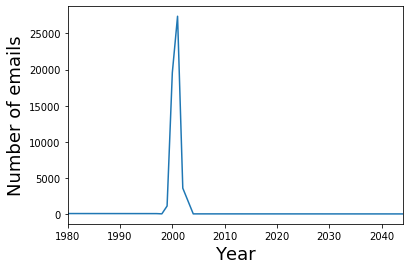

In [23]:
ax = emails_df.groupby(emails_df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Number of emails', fontsize=18)

Looks like the total number of emails really ramped up in 2000 and 2001

I am going to exlore even more that period


Text(0, 0.5, 'Number of emails')

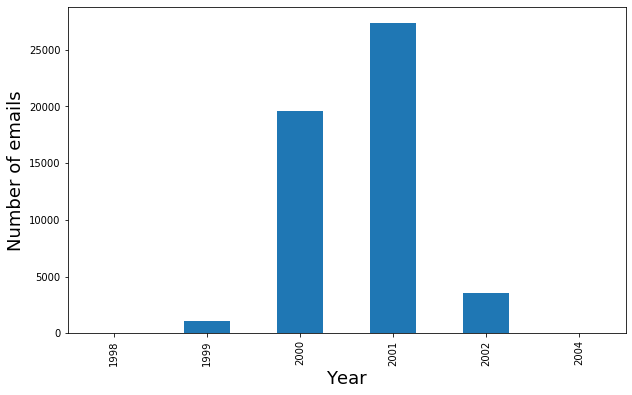

In [24]:
emails_df['Year'] = emails_df['Date'].dt.year

indices = (emails_df['Year'] >= 1998) & (emails_df['Year'] <= 2005)
plt.figure(figsize = (10,6))
figure1 = emails_df.loc[indices].groupby('Year')['content'].count().plot(kind = 'bar')
figure1.set_xlabel('Year', fontsize=18)
figure1.set_ylabel('Number of emails', fontsize=18)

BY MONTH


Text(0, 0.5, 'Number of emails')

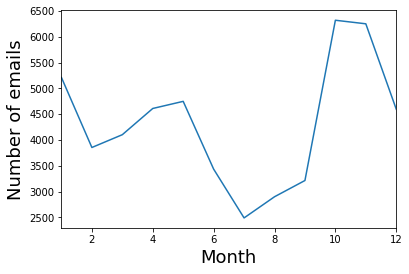

In [25]:

ax = emails_df.groupby(emails_df['Date'].dt.month)['content'].count().plot()
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Number of emails', fontsize=18)

BY DAY

Text(0, 0.5, 'Number of emails')

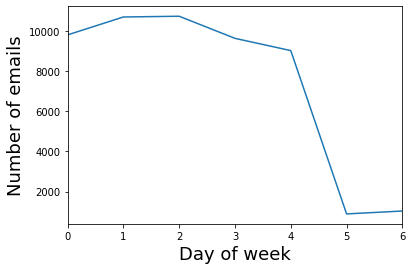

In [26]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('Number of emails', fontsize=18)

BY HOUR

Text(0, 0.5, 'Number of emails')

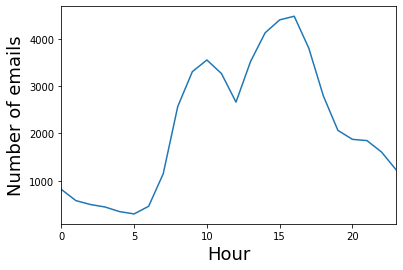

In [27]:
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('Number of emails', fontsize=18)

### Who sends most emails?

In [28]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [29]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()


,N emails,Subject word count,Content word count
user,,,
kaminski-v,2847,4.189322,255.852828
dasovich-j,2824,5.240085,586.227691
kean-s,2535,4.884813,522.583432
mann-k,2338,4.257485,201.464500
jones-t,1995,4.846115,176.146366


### Who sends the most emails to whom

In [30]:
sub_df = emails_df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(49542, 3)
(35468, 3)


In [31]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
5877,pete.davis@enron.com,pete.davis@enron.com,920
11719,vince.kaminski@enron.com,vkaminski@aol.com,430
9449,enron.announcements@enron.com,all.worldwide@enron.com,220
9447,enron.announcements@enron.com,all.houston@enron.com,180
893,kay.mann@enron.com,suzanne.adams@enron.com,146
11712,vince.kaminski@enron.com,shirley.crenshaw@enron.com,108
5231,steven.kean@enron.com,maureen.mcvicker@enron.com,102
767,kay.mann@enron.com,nmann@erac.com,91
892,kay.mann@enron.com,kathleen.carnahan@enron.com,89
2897,evelyn.metoyer@enron.com,kate.symes@enron.com,88


Apparently some people send a lot of emails to themselves.

### What do most emails say? (in the content)

(-0.5, 799.5, 599.5, -0.5)

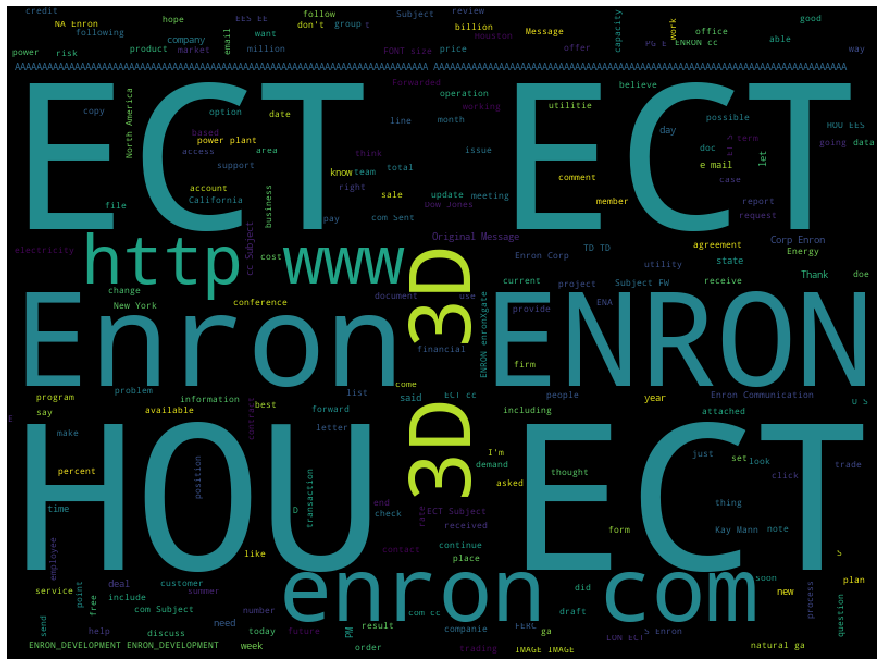

In [32]:
contents = ' '.join(emails_df.sample(5000)['content'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")

# Machine Learining


In [33]:
emails_df['user'].value_counts()

kaminski-v        2847
dasovich-j        2824
kean-s            2535
mann-k            2338
jones-t           1995
shackleton-s      1869
taylor-m          1387
farmer-d          1303
germany-c         1244
beck-s            1183
symes-k           1083
nemec-g           1066
scott-s            802
rogers-b           801
bass-e             782
sanders-r          733
campbell-l         649
shapiro-r          607
guzman-m           606
lay-k              594
lenhart-m          592
lokay-m            557
kitchen-l          554
haedicke-m         524
sager-e            520
love-p             500
arnold-j           490
fossum-d           479
perlingiere-d      477
lavorato-j         469
                  ... 
hendrickson-s       72
ring-a              71
mccarty-d           69
mckay-b             68
arora-h             65
townsend-j          65
scholtes-d          64
pimenov-v           64
staab-t             62
gang-l              59
richey-c            58
platter-p           57
gilbertsmit

In [34]:
df_grouped = emails_df.groupby("user")['content'].apply(' '.join).reset_index()
df_grouped.head()

,user,content
0,allen-p,---------------------- Forwarded by Phillip K ...
1,arnold-j,"how about 6:00 for drinks\n\n\n\n\n\n""Mark Sag..."
2,arora-h,"Hi Harry, thank you for sending us Linda Wolf'..."
3,badeer-r,---------------------- Forwarded by Robert Bad...
4,bailey-s,"As you may be aware, Enron Corp. is a member o..."


First, I need to vectorise the words of the text, so I can use the text as a feature to train the ML models.

In [35]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
features = vectorizer.fit_transform(df_grouped['content'])

I want to add the target feature, which is whether or not the person 
is a POI or not (in order to determine which person are POIs)

In [36]:
poi_names = ['lay-k', 'skilling-j', 'forney-j', 'delainey-d']
df_grouped['poi'] = 0

for idx, name in enumerate(df_grouped['user']):
    if name in poi_names:
        df_grouped.loc[idx, 'poi'] = 1
        
print("Number of POI : {}".format(sum(df_grouped['poi'])))

Number of POI : 4


In [37]:
df_grouped.head(10)

,user,content,poi
0,allen-p,---------------------- Forwarded by Phillip K ...,0
1,arnold-j,"how about 6:00 for drinks\n\n\n\n\n\n""Mark Sag...",0
2,arora-h,"Hi Harry, thank you for sending us Linda Wolf'...",0
3,badeer-r,---------------------- Forwarded by Robert Bad...,0
4,bailey-s,"As you may be aware, Enron Corp. is a member o...",0
5,bass-e,It only takes about 10 minutes to get to highl...,0
6,baughman-d,https://clickathomepilot.enron.com/signup.asp\...,0
7,beck-s,I hope that your holidays were wonderful. I t...,0
8,benson-r,"George,\n\n I'll book a tee time for around 9:...",0
9,blair-l,FYI. I am sure you are already up to speed. ...,0


### SPLITTING DATA INTO TRAIN AND TEST

If we randomly split the dataset, there is a chance that all of the POIs are only present in the training set or testing set  (since the number of POIs are only 4). So in order to prevent that, I will choose 70% of the data which are not POI as training data, then manually add 3 of the 4 POIs to the training data. Then the rest of the data will be used as testing data.

In [38]:
df_grouped[df_grouped['poi']==1]

,user,content,poi
22,delainey-d,"guys, phone numbers:\n\nHome: 713-592-9723\nC...",1
31,forney-j,\n\n -----Original Message-----\nFrom: \tNicol...,1
63,lay-k,"Ken Lay wrote:\n\n""Loyal -\n\nI was really dis...",1
118,skilling-j,"Not necessary yet, Karen, but thanks. Fitz is...",1


The below method was found from the internet

In [39]:
poi_idx = df_grouped.index[df_grouped['poi']==1].to_list()

#select rows that are not POI, then shuffle the index
shuffle_idx = [idx for idx in df_grouped.index.to_list() if idx not in poi_idx]
random.shuffle(shuffle_idx)

#select 70% as training data, then add 3 more data which are POIs
train_idx = shuffle_idx[:round(len(shuffle_idx)*0.7)]
train_idx = train_idx + poi_idx[:3]

#select the rest as test data, adding 1 more data which is POI
test_idx = shuffle_idx[round(len(shuffle_idx)*0.7):]
test_idx = test_idx + poi_idx[3:]

In [40]:
df_train = df_grouped.loc[train_idx, :].reset_index(drop=True)
df_test = df_grouped.loc[test_idx, :].reset_index(drop=True)
df_train.head()

,user,content,poi
0,king-j,"KING, JEFF N,\n?\nThe PEP system closes on Fri...",0
1,haedicke-m,fyi\n----- Forwarded by Mark E Haedicke/HOU/EC...,0
2,harris-s,Summary Risk Data as of \t20Dec2001\tPrevious\...,0
3,watson-k,\n\nAttached are my notes from the open seaso...,0
4,dasovich-j,The next AB 1890 Implementation Group meeting ...,0


### BUILDING THE MODELS

For the models, I will use several classification algorithms : 
decision tree, naive-bayes, k-nearest neighbor, and adaboost.

In [41]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
features_train = vectorizer.fit_transform(df_train['content']).toarray()
features_test = vectorizer.transform(df_test['content']).toarray()

In [42]:
#decision tree
dt_clf = DecisionTreeClassifier()
dt_clf.fit(features_train, df_train['poi'])
dt_pred = dt_clf.predict(features_test)

#gaussian naive-bayes
nb_clf = GaussianNB()
nb_clf.fit(features_train, df_train['poi'])
nb_pred = nb_clf.predict(features_test)

#knn
knn_clf = KNeighborsClassifier()
knn_clf.fit(features_train, df_train['poi'])
knn_pred = knn_clf.predict(features_test)

#adaboost
ab_clf = GradientBoostingClassifier()
ab_clf.fit(features_train, df_train['poi'])
ab_pred = ab_clf.predict(features_test)

preds = {"Decision Tree":dt_pred,
         "Naive-bayes":nb_pred,
         "K-Nearest Neighbor":knn_pred,
         "Adaboost":ab_pred}

Confusion Matrix

In [43]:
for pred in preds:
    print("\n", pred)
    print(pd.DataFrame(confusion_matrix(df_test['poi'], preds[pred]), 
                 columns=["0(Predicted)", "1(Predicted)"], index=["0(Actual)", "1(Actual)"]))


 Decision Tree
           0(Predicted)  1(Predicted)
0(Actual)            44             0
1(Actual)             1             0

 Naive-bayes
           0(Predicted)  1(Predicted)
0(Actual)            44             0
1(Actual)             1             0

 K-Nearest Neighbor
           0(Predicted)  1(Predicted)
0(Actual)            44             0
1(Actual)             1             0

 Adaboost
           0(Predicted)  1(Predicted)
0(Actual)            44             0
1(Actual)             1             0


From the result,  can see that the classifiers cannot detect the prescence of the POI in the test set. All of the classifiers predicted that the actual POI is not a POI. 

## Conclusion

From the result of the ML models predictions, it looks like the emails of the 4 POI in the dataset are not accurate enough to detect the prescence of POIs. There is another approach that it could be done, using multi-layer perceptron classifier, but I had a problem with the size of the array. After some investigation with this deep learing approach online, I found that neither this approach-method works and the neural network aren't able to detect the POI.


Thanks for your time and consideration.


Andreas Neofytou